# Measure GRACE performance on identified objects:

### All metrics here are **exact**, i.e measure similarity between two graphs formed of identical node count which have the same positions. The only thing that differs between the graphs is the edges and object membership / individual identities. 

*Note:* The rationale behind evaluating the per-node and per-edge metrics at this stage is that the optimisation step can (and most likely will) change the identities of the individual nodes / edges when looking for a globally optimal solution. For example, a single node be predicted (by the GCN / classification method of choice) to have a high probability of being considered a real node (true positive, TP), but if such node is surrounded by no other plausible nodes or forms no acceptable edges, it has a high likelihood to be considered a fake node (true negative, TN) in favour of the global optimisation. This is why evaluation of the node- & edge-specific metrics is vital to observe the changes made to the graph components as a result of the optimisation step.

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.metrics import (
    confusion_matrix, 
    precision_recall_fscore_support,
    jaccard_score,
)


In [2]:
from grace.base import GraphAttrs
from grace.models.optimiser import optimise_graph

from grace.io.image_dataset import generate_ground_truth_graph

from grace.simulator.simulate_graph import (
    random_graph, 
    update_graph_with_dummy_predictions, 
    imply_annotations_from_dummy_predictions
)

from grace.evaluation.visualisation import (
    plot_simple_graph,
    plot_connected_components
)


### Generate a random graph, update dummy labels & generate GT graph:

In [3]:
G = random_graph(n_motifs=5, density=0.05)
node_conf, edge_conf = 0.5, 0.1
update_graph_with_dummy_predictions(
    G, 
    node_confidence=node_conf, 
    edge_confidence=edge_conf
)
imply_annotations_from_dummy_predictions(G)

In [4]:
true_graph = generate_ground_truth_graph(G)
true_graph

In [5]:
# node_conf, edge_conf = 0.5, 0.3
# update_graph_with_dummy_predictions(
#     G, 
#     node_confidence=node_conf, 
#     edge_confidence=edge_conf
# )
pred_graph = optimise_graph(G)
pred_graph

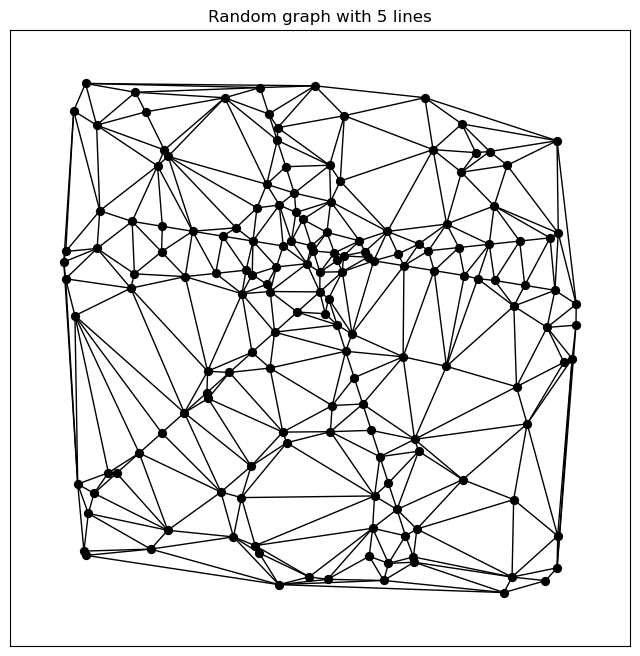

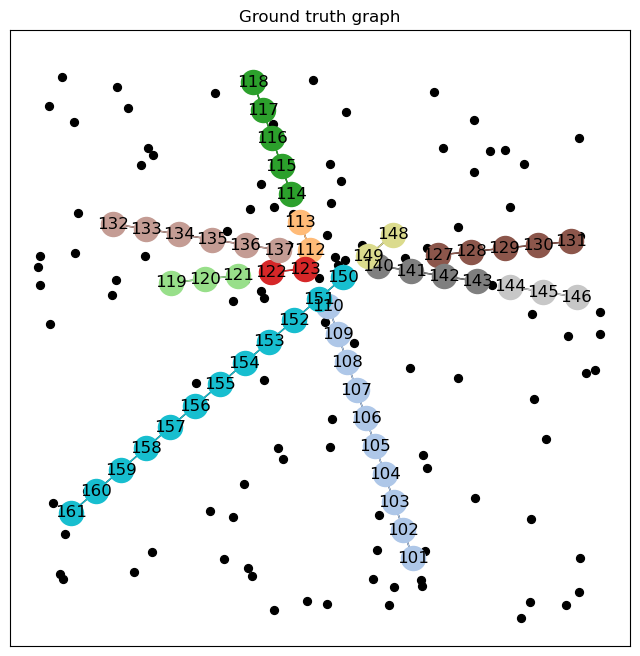

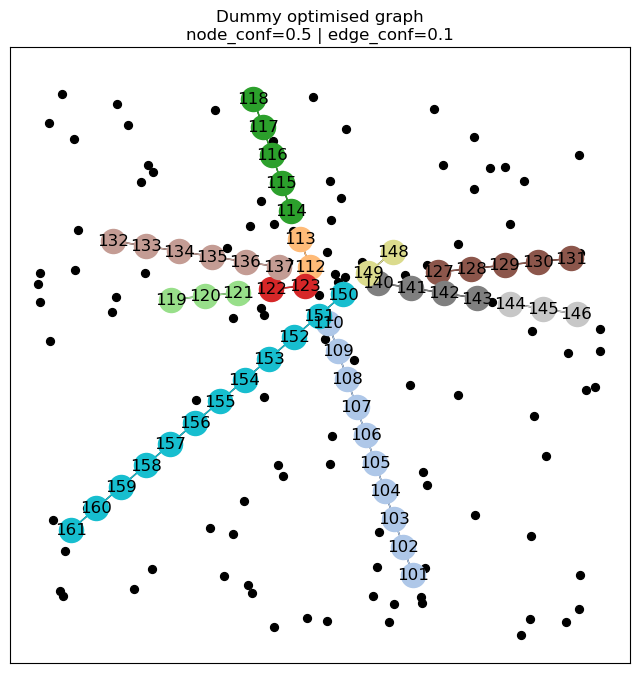

In [6]:
figsize = (8, 8)
plot_simple_graph(G, figsize=figsize, title="Random graph with 5 lines")
plot_connected_components(true_graph, figsize=figsize, title=f"Ground truth graph")
plot_connected_components(pred_graph, figsize=figsize, title=f"Dummy optimised graph\nnode_conf={node_conf} | edge_conf={edge_conf}")


### Perform checks:

In [73]:
assert pred_graph.number_of_nodes() == true_graph.number_of_nodes()
assert pred_graph.number_of_edges() == true_graph.number_of_edges()


### simple confusion matrix?

In [74]:
def pool_connected_components_nodes(G: nx.Graph) -> set[int]:

    con_pool = set()
    cc = nx.connected_components(G)
    for comp in cc:
        # Ignore 1-node components:
        if len(comp) > 1:
            con_pool.update(comp)
    return con_pool

In [75]:
def pool_connected_components_edges(G: nx.Graph) -> set[int]:

    con_pool = set()
    cc = nx.connected_components(G)
    for comp in cc:
        if len(comp) > 1:
            for i in range(len(list(comp)) - 1):
                src, dst = list(comp)[i:i+2]
                con_pool.update([(src, dst), (dst, src)])
    return con_pool


In [76]:
con_pool_pred_nodes = pool_connected_components_nodes(pred_graph)
con_pool_pred_edges = pool_connected_components_edges(pred_graph)
con_pool_true_nodes = pool_connected_components_nodes(true_graph)
con_pool_true_edges = pool_connected_components_edges(true_graph)


In [77]:
# Iterate through node indices, check if their belonging agrees between graphs. Same for the edges:
# Pool all the connected components into a single, large set. That will be the pool to evaluate.


### Generalise the conf matrix + accuracy, precision, recall & f-score:

In [106]:
def generate_label_vector(input_data_set: set, component_pool_set: set):
    y_labels = [n in component_pool_set for n in input_data_set]
    y_labels = np.array(y_labels).astype(int)
    return y_labels

In [107]:
y_pred_nodes = generate_label_vector(input_data_set=G.nodes(data=False), component_pool_set=con_pool_pred_nodes)
y_true_nodes = generate_label_vector(input_data_set=G.nodes(data=False), component_pool_set=con_pool_true_nodes)

y_pred_edges = generate_label_vector(input_data_set=G.edges(data=False), component_pool_set=con_pool_pred_edges)
y_true_edges = generate_label_vector(input_data_set=G.edges(data=False), component_pool_set=con_pool_true_edges)


In [109]:
cm_nodes_all = confusion_matrix(y_pred=y_pred_nodes, y_true=y_true_nodes)
cm_edges_all = confusion_matrix(y_pred=y_pred_edges, y_true=y_true_edges)
cm_nodes_all, cm_edges_all

(array([[108,   0],
        [  0,  54]]),
 array([[428,   0],
        [  0,  40]]))

In [111]:
cm_nodes_nrm = confusion_matrix(y_pred=y_pred_nodes, y_true=y_true_nodes, normalize='true')
cm_edges_nrm = confusion_matrix(y_pred=y_pred_edges, y_true=y_true_edges, normalize='true')
cm_nodes_nrm, cm_edges_nrm

(array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]))

In [110]:
prf1_nodes = precision_recall_fscore_support(y_pred=y_pred_nodes, y_true=y_true_nodes)
prf1_nodes

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([108,  54]))

In [229]:
prf1_nodes = precision_recall_fscore_support(y_pred=y_pred_edges, y_true=y_true_edges)
prf1_nodes

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([428,  40]))

### *Semantic* vs. *instance* IoU calculation:

Intersection over union is calculated purely on the object level, therefore we can assume that the edge-specific information can be discarded at this point. 

*Note:* This entire method assumes that the object must form an edge, _i.e._ that an object cannot exist in isolation. This is an **assumption* we are making, not a universal truth. For example, when detecting roads in an image, it is unlikely that only a single local detection would correspond to a road. But this possibility cannot be excluded, for example if the road leads to a tunnel from one side and an airplane flew over it from the other side (2 different types of _object occlusion_). With our methodology, this isolated detection would not be considered a self-standing object. 

*Note:* Area under curve (AUC) metric is not applicable here, because the optimisation step 'strips off' the probabilities of predictions - all decisions here, _i.e._ to accept or reject a hypothesis of an existing node / edge, are of binary nature, all-or-nothing. The optimiser doesn't think that an edge is accepted with a certain probability, it just accepts or rejects it and it's decision is final. I think...

*Note:* METHOD LIMITATIONS: 
* relies on previous detections -> if an object is not detected(as in, is presented as a candidate node), it has no chance to appear in the final solution. This means:
  * we supply sparse but highly accurate detections must capture all objects (_e.g._ cryolo confidence threshold = 0.7)
  * we decrease the detection confidence threshold in belief that noisy detections will be filtered out by the classifier / optimiser (_e.g._ cryolo confidence threshold = 0.0)
  * we include all possible detections from the detection algorithm PLUS add some randomly picked positions just to make sure, making the same assumption as in the step before
* to avoid the limitation where we rely on an auxiliary particle picker, we could, in theory, sample a lot of random patches & let the pipeline just filter the clean / real nodes & links between them. This is a very romantic idea and I'm skeptical in claiming that this pipeline will "just figure itself out". But we don't know until we try... 
* our napari-based annotator GUI only provides an option to annotate objects _semantically_, _i.e._ with a single-valued brush, producing a binary mask. This could/should be addressed in later developments.

*Note to self:* We need to provide a (graphical) glossary / appendix where we describe the methodology / name the terms. Detection, object, graph, connection, instance, segment etc.


In [117]:
jaccard_score(y_true=y_true_nodes, y_pred=y_pred_nodes)


1.0

In [123]:
def intersection_over_union(set_1: set, set_2: set):

    # Calculate the intersection of sets
    intersection = len(set_1.intersection(set_2))

    # Calculate the union of sets
    union = len(set_1.union(set_2))

    if union < 1:
        return 0
    else:
        return intersection / union


### This is **SEMANTIC** object detection - all nodes pooled together:


In [126]:
intersection_over_union(con_pool_pred_nodes, con_pool_true_nodes)


1.0

### This is **INSTANCE** object detection: objects evaluated per identity:

In [150]:
def list_real_connected_components(graph: nx.Graph) -> list[set[int]]:
    """Filter through instance sets."""
    connected_comps = nx.connected_components(graph)
    con_comp_sets = []
    for comp in connected_comps:
        if len(comp) <= 1: continue
        con_comp_sets.append(comp)
    return con_comp_sets


In [160]:
# def map_nodes_to_sets(node_indices: list[int], con_comp_sets: list[set[int]]) -> dict[int, int]:
#     """Create a dictionary that maps nodes to sets."""
#     node_to_set = {}
#     for idx, node_set in enumerate(con_comp_sets):
#         for node in node_set:
#             node_to_set[node] = idx
#     return node_to_set


In [161]:
con_comp_sets_pred = list_real_connected_components(pred_graph)
con_comp_sets_true = list_real_connected_components(true_graph)

# node_indices = G.nodes(data=False)
# map_pred = map_nodes_to_sets(node_indices, con_comp_sets_pred)
# map_true = map_nodes_to_sets(node_indices, con_comp_sets_true)

# map_pred, map_true

In [162]:
# # Iterate through the list of nodes and find the set each node belongs to

# node_dict = {n : None for n in node_indices}
# iou_list = []

# for node_idx in node_indices:
#     if node_idx not in map_pred and node_idx not in map_true:
#         # index present in no list, good!
#         continue
#     if node_idx not in map_pred and node_idx in map_true:
#         # underdetected node:
#         current_set = con_comp_sets_true[map_true[node_idx]]
#         print ("under", current_set)
#     if node_idx in map_pred and node_idx not in map_true:
#         # overdetected node:
#         current_set = con_comp_sets_pred[map_pred[node_idx]]
#         print ("over", current_set)
#     if node_idx in map_pred and node_idx in map_true:
#         # match! calculate iou!
#         set_pred = con_comp_sets_pred[map_pred[node_idx]]
#         set_true = con_comp_sets_true[map_true[node_idx]]
#         iou = intersection_over_union(set_pred, set_true)
#         print ("iou", iou)
#         iou_list.append(iou)

#     # node_set_index = map_pred.get(node_idx)

#     # if node_set_index is not None:
#     #     print(f"{node_idx} belongs to set {node_set_index}")
#     # else:
#     #     print(f"{node_idx} does not belong to any set")


In [164]:
def find_matching_pairs(list_of_sets1, list_of_sets2):
    matching_pairs = []
    for set1 in list_of_sets1:
        for set2 in list_of_sets2:
            if len(set1.intersection(set2)) > 0:
                matching_pairs.append((set1, set2))
    return matching_pairs


In [166]:
# Find matching pairs of sets with at least one common node
matching_pairs = find_matching_pairs(con_comp_sets_pred, con_comp_sets_true)

iou_list = []
for pair in matching_pairs:
    iou_score = intersection_over_union(pair[0], pair[1])
    print("Matching Pair:", pair)
    print("IoU Score:", iou_score)
    iou_list.append(iou_score)


Matching Pair: ({101, 102, 103, 104, 105, 106, 107, 108, 109, 110}, {101, 102, 103, 104, 105, 106, 107, 108, 109, 110})
IoU Score: 1.0
Matching Pair: ({112, 113}, {112, 113})
IoU Score: 1.0
Matching Pair: ({114, 115, 116, 117, 118}, {114, 115, 116, 117, 118})
IoU Score: 1.0
Matching Pair: ({120, 121, 119}, {120, 121, 119})
IoU Score: 1.0
Matching Pair: ({122, 123}, {122, 123})
IoU Score: 1.0
Matching Pair: ({128, 129, 130, 131, 127}, {128, 129, 130, 131, 127})
IoU Score: 1.0
Matching Pair: ({132, 133, 134, 135, 136, 137}, {132, 133, 134, 135, 136, 137})
IoU Score: 1.0
Matching Pair: ({140, 141, 142, 143}, {140, 141, 142, 143})
IoU Score: 1.0
Matching Pair: ({144, 145, 146}, {144, 145, 146})
IoU Score: 1.0
Matching Pair: ({148, 149}, {148, 149})
IoU Score: 1.0
Matching Pair: ({160, 161, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159}, {160, 161, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159})
IoU Score: 1.0


# ^^^ Individual IoU scores per object:

Remember, the object needs to be evaluated multiple times it is if present (member of) multiple objects. 

### Visualisation ideas:
+ wrap up numerical table
+ Jaccard index histogram
+ bounding boxes (find outermost coords)
+ if object is in both graphs, green
+ if in pred only, yellow
+ if in true only, blue 
* etc..


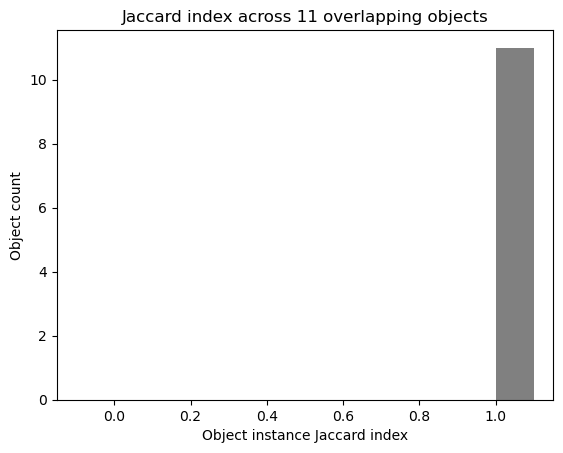

In [231]:
plt.hist(iou_list, color='grey')
plt.xlim(-0.15, 1.15)
plt.xlabel("Object instance Jaccard index")
plt.ylabel("Object count")
plt.title(f"Jaccard index across {len(matching_pairs)} overlapping objects")
plt.show()

### Colour-code the graph:

In [176]:
matching_pairs

[({101, 102, 103, 104, 105, 106, 107, 108, 109, 110},
  {101, 102, 103, 104, 105, 106, 107, 108, 109, 110}),
 ({112, 113}, {112, 113}),
 ({114, 115, 116, 117, 118}, {114, 115, 116, 117, 118}),
 ({119, 120, 121}, {119, 120, 121}),
 ({122, 123}, {122, 123}),
 ({127, 128, 129, 130, 131}, {127, 128, 129, 130, 131}),
 ({132, 133, 134, 135, 136, 137}, {132, 133, 134, 135, 136, 137}),
 ({140, 141, 142, 143}, {140, 141, 142, 143}),
 ({144, 145, 146}, {144, 145, 146}),
 ({148, 149}, {148, 149}),
 ({150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161},
  {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161})]

In [210]:
def locate_rectangle_points(object_node_set: set, G: nx.Graph):

    nodes = G.nodes(data=True)
    x_coords, y_coords = [], []
    
    for node_idx in object_node_set:
        y_coords.append(nodes[node_idx][GraphAttrs.NODE_Y])
        x_coords.append(nodes[node_idx][GraphAttrs.NODE_X])
    
    x_mn, x_mx = np.min(x_coords), np.max(x_coords) 
    y_mn, y_mx = np.min(y_coords), np.max(y_coords)

    return (x_mn, y_mn), x_mx-x_mn, y_mx-y_mn  # anchor, height, width
    

In [236]:
rectangles = []
color_list = ['limegreen', 'gold', 'dodgerblue']
legend_handle = {
    'limegreen' : 'perfect match', 
    'gold' : 'only in predicted graph', 
    'dodgerblue' : 'only in ground truth',
}

for pair in matching_pairs:
    
    # Check if objects are equal: 
    if pair[0] == pair[1]:
        anchor, height, width = locate_rectangle_points(pair[0], G)
        rectangles.append((anchor, height, width, color_list[0]))
    
    else:
        # Unwrap both & store rectangle coords + correct colour:
        for o, obj in enumerate(pair):
            anchor, height, width = locate_rectangle_points(pair[o], G)
            rectangles.append((anchor, height, width, color_list[0+1]))


In [237]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))


In [238]:
def visualise_object_bounding_boxes_on_graph(G: nx.Graph, rectangles: list[tuple[float]], legend_handle: dict[str, str], figsize: tuple[int] = (10, 10)) -> None:
    """TODO: Fill in."""
    # Create figure and axes
    _, ax = plt.subplots(figsize=figsize)

    # Display the graph node positions
    pos = {
        idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y])
        for idx, node in G.nodes(data=True)
    }

    # draw all nodes/vertices in the graph
    nx.draw_networkx(
        G, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32
    )

    # plot the rectangles one by one
    for rectangle in rectangles:
        anchor, height, width, color = rectangle
        handle = legend_handle[color]
        rect = patches.Rectangle(anchor, height, width, label=handle,
            linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        legend_without_duplicate_labels(ax)

    ax.set_title("IoU metric illustration on per-object level")
    plt.show()


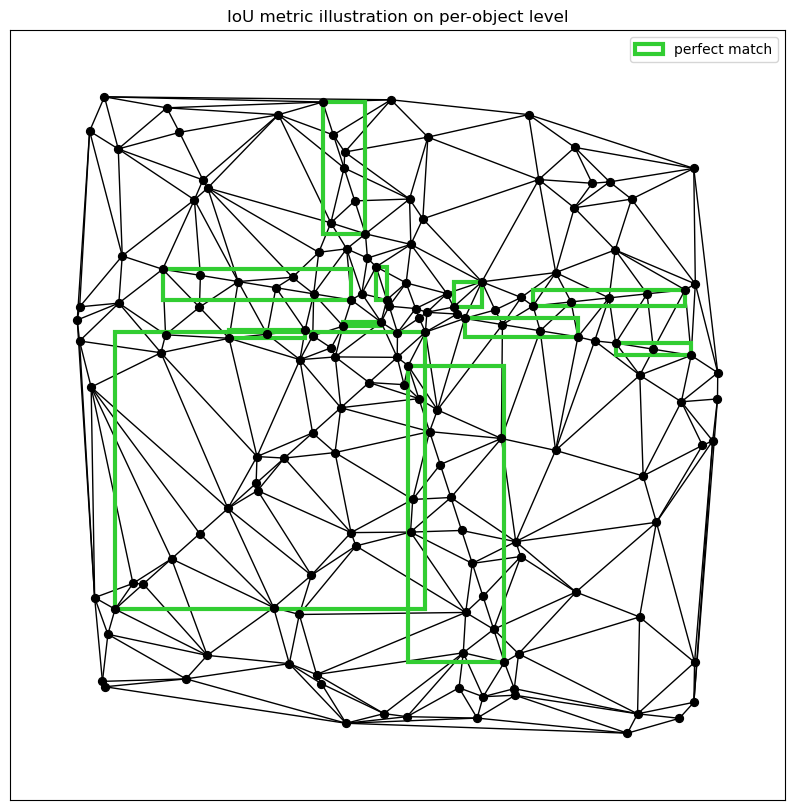

In [239]:
visualise_object_bounding_boxes_on_graph(G, rectangles, legend_handle)

# TODO:

1. randomly add some edges
2. randomly remove some edges
3. randomly add & remove some edges


## Randomly adding some edges

## Randomly removing some edges

## Randomly adding & removing some edges